In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
from IPython.display import display
import pandas as pd


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [43]:
#cms_corrected_rawjet = cms_rawjet * np.sqrt((2.5 - 0.15 * abs(cms_jet_eta)) ** 2 / cms_rawjet + 1.0)

file_path = "/mnt/12TB/jet_omer/cms_jet_data.h5"
key = "data"
data = pd.read_hdf(file_path, key=key)


In [44]:
df = pd.DataFrame(data)
df_filtered = df[df["jetGenMatch"] != 0]
df_filtered = df_filtered.head(1000000)
df_filtered

,jetPt,genJetPt,jetRawPt,jetEta,jetPhi,jetMass,jetGenMatch,QG_ptD,QG_mult,QG_axis2,jetArea
0,201.199554,201.982956,191.304138,-0.455842,-1.927541,20.587746,1,0.489665,16,0.009762,0.488692
1,154.892838,156.991348,148.450638,0.014880,1.769757,18.438292,1,0.311253,26,0.027024,0.488692
2,105.403564,104.787613,91.705650,-2.155736,0.339309,17.063622,1,0.520251,11,0.028507,0.478719
3,1263.015747,1230.496338,1196.449341,0.024581,-1.778938,65.909691,1,0.464368,21,0.005259,0.498666
4,742.551147,783.408325,695.258301,-0.602228,1.542989,67.713173,1,0.484394,48,0.008470,0.488692
...,...,...,...,...,...,...,...,...,...,...,...
1010900,1559.649536,1548.604980,1463.958862,0.808135,-3.035028,114.442963,1,0.278815,55,0.009796,0.518612
1010901,40.510204,37.715134,35.541321,2.478965,-1.665614,7.483438,1,0.474315,7,0.059738,0.528585
1010902,51.257782,66.489876,45.941383,-1.696009,1.871044,9.119467,1,0.502128,10,0.045420,0.508639
1010903,33.402176,28.113699,32.452595,0.140402,-1.168036,4.338906,1,0.459305,8,0.025856,0.508639


In [45]:
#df = df[abs(df["raw_jet_eta"])<5.]
#df['delphes_corrected_pt'] = df['raw_jet_pt'] * np.sqrt((2.5 - 0.15 * abs(df['raw_jet_eta'])) ** 2 / df['raw_jet_pt'] + 1.0)

exclude_columns = ["genJetPt", "jetRawPt", "jetGenMatch"]

features = df_filtered[[col for col in df.columns if col not in exclude_columns]]
target = df_filtered["genJetPt"]


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)



In [46]:
genJetPt = target.to_numpy()
jetRawPt = df_filtered["jetRawPt"].to_numpy()
jetPt = df_filtered["jetPt"].to_numpy()

In [47]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features_scaled, target):
        self.features_scaled = torch.tensor(features_scaled, dtype=torch.float32)
        self.target = torch.tensor(target.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.features_scaled)

    def __getitem__(self, idx):
        return self.features_scaled[idx], self.target[idx]



In [48]:

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, target, test_size=0.4, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
    
        
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 256)  
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, 128) 
        self.layer6 = nn.Linear(128, 64) 
        self.layer7 = nn.Linear(64, 128)
        self.layer8 = nn.Linear(128, 256)
        self.layer9 = nn.Linear(256,256)
        self.layer10 = nn.Linear(256, 1) # Output layer with a single unit for regression

    def forward(self, x):
        x = F.relu(self.layer1(x))  # ReLU activation
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        x = F.relu(self.layer6(x))
        x = F.relu(self.layer7(x))
        x = F.relu(self.layer8(x))
        x = F.relu(self.layer9(x))
        output = self.layer10(x)
        return output


l1_reg = 0.01 # Strength of L1 regularization
l2_reg = 0.01 # Strength of L2 regularization


device = 'cuda'

model = MyModel(X_train.shape[1])
model = model.to(device)
model = nn.DataParallel(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003) 

In [50]:
def leaky_gaussian_loss(pred, target, alpha, beta):
    
    pred = pred.cpu()
    target = target.cpu()

    # Calculate the loss using PyTorch operations
    loss = -torch.exp(-(target - pred)**2 / (2 * alpha)) + (beta * torch.abs(target - pred))
    
    return torch.mean(loss)
    

alpha = 0.001
beta = 0.01

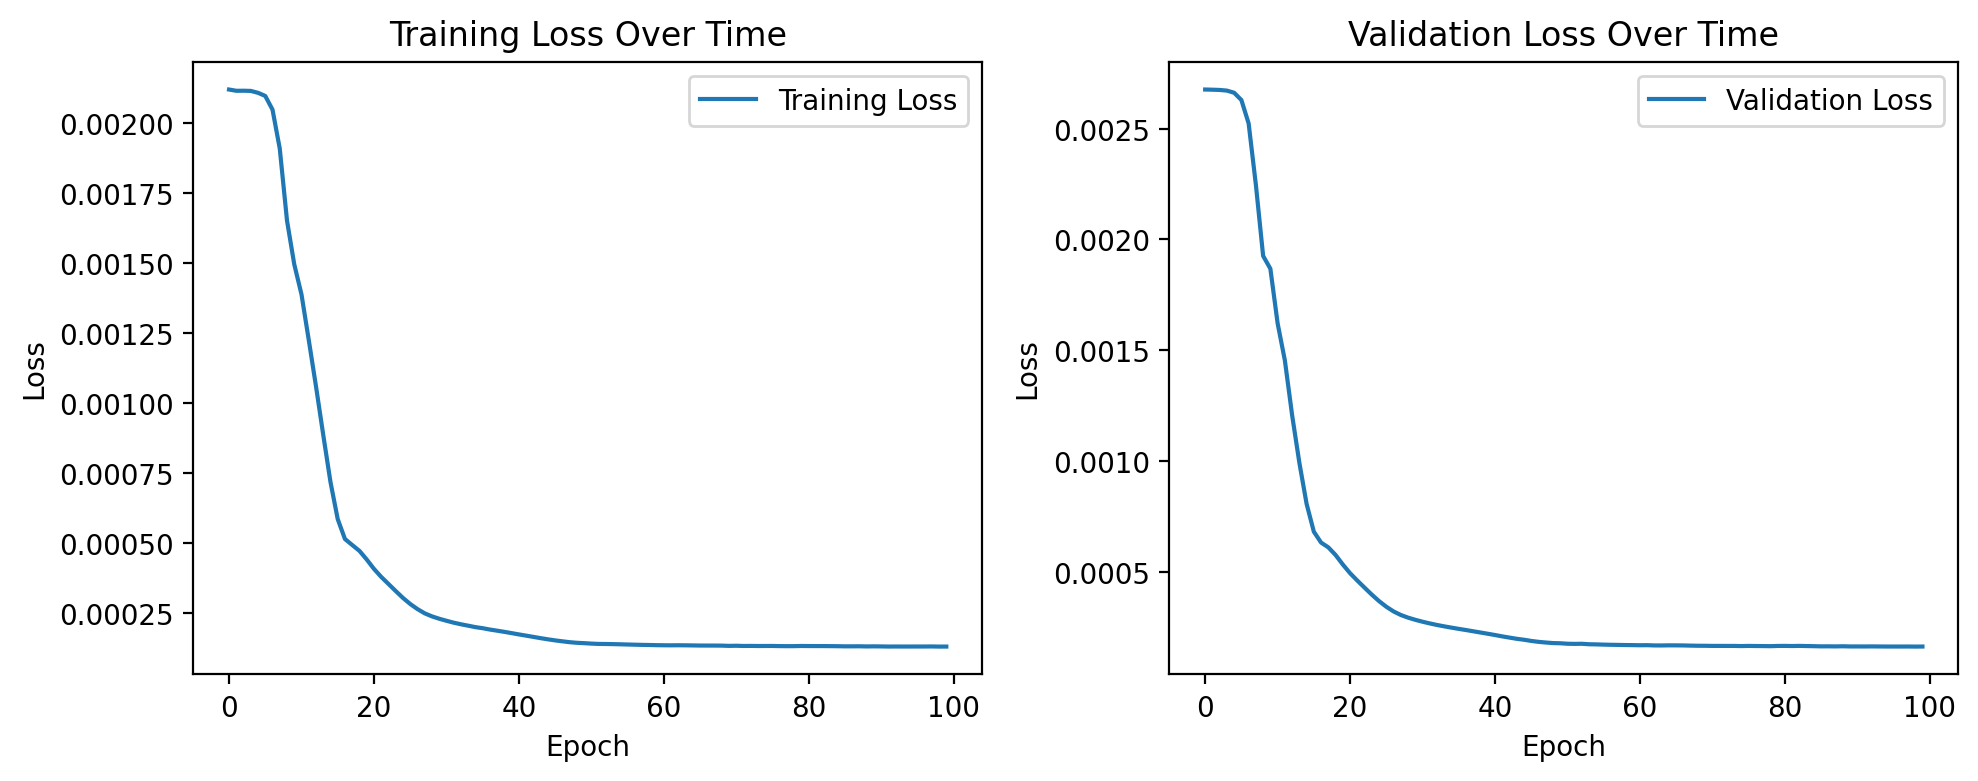

100%|██████████| 100/100 [15:04<00:00,  9.05s/it]


In [51]:
import tqdm
from sklearn.metrics import r2_score
from IPython.display import clear_output


#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()


train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
validation_dataset = CustomDataset(X_validation, y_validation)

batch_size = int(2**17)  
#batch_size = int(2**20)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)



patience = 10
best_val_loss = float('inf')
counter = 0
EPOCHS = 100


# Training loop
loss_list = np.zeros((EPOCHS,))
r2_list = np.zeros((EPOCHS,))
val_loss_list = np.zeros((EPOCHS,))
val_r2_list = np.zeros((EPOCHS,))


# Create empty lists to store loss values for training and validation plotting
train_loss_history = []
val_loss_history = []


for epoch in tqdm.trange(EPOCHS):
    
    # Training phase
    model.train()  
    for inputs, targets in tqdm.tqdm(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, targets.view(y_pred.shape))
        #loss = leaky_gaussian_loss(y_pred, targets.view(y_pred.shape), alpha, beta)
        loss_list[epoch] += loss.item()/len(targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate R-squared for the current training batch
        r2_batch = r2_score(targets.cpu().numpy(), y_pred.cpu().detach().numpy())
        r2_list[epoch] += r2_batch

    
    # Compute the training loss for the epoch
    loss_list[epoch] /= len(train_loader)
    r2_list[epoch] /= len(train_loader)

    
    
    # Validation phase ------------------------------------------------------------------------------------------
    model.eval()  
    with torch.no_grad():
        val_loss = 0.0
        y_true_val = []
        y_pred_val = []
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            y_pred = model(inputs)
            val_loss += loss_fn(y_pred, targets.view(y_pred.shape)).item()/len(targets)
            #val_loss += leaky_gaussian_loss(y_pred, targets.view(y_pred.shape), alpha, beta).item()/len(targets)
            y_true_val.extend(targets.cpu().numpy())
            y_pred_val.extend(y_pred.cpu().numpy())

        # Compute the validation loss for the epoch
        val_loss /= len(validation_loader)

        # Calculate R-squared for validation
        r2_val = r2_score(y_true_val, y_pred_val)


        # Store the validation loss and R-squared values
        val_loss_list[epoch] = val_loss
        val_r2_list[epoch] = r2_val

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save the model if needed
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    
    
    # Append the loss values to the history lists
    train_loss_history.append(loss_list[epoch])
    val_loss_history.append(val_loss_list[epoch])



    # Dynamic Loss plot -----------------------------------------------------------------------------------

    # Update and display the dynamic loss plot
    clear_output(wait=True)

    plt.figure(figsize=(10, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch + 1), train_loss_history, label="Training Loss")
    #plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()

    # Plot validation loss
    plt.subplot(1, 2, 2)
    plt.plot(range(epoch + 1), val_loss_history, label="Validation Loss")
    #plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss Over Time")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [52]:
# Testing loop -----------------------------------------------------------------------------------
test_loss = 0.0
y_true_test = []
y_pred_test = []


model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs  = inputs.to(device)
        targets = targets.to(device) 
        y_pred = model(inputs)
        #test_loss += loss_fn(y_pred, targets.view(y_pred.shape)).item()/len(targets)
        test_loss += leaky_gaussian_loss(y_pred, targets.view(y_pred.shape), alpha, beta).item()/len(targets)
        
        y_true_test.extend(targets.cpu().numpy())
        y_pred_test.extend(y_pred.cpu().numpy())

# Compute the test loss
test_loss /= len(test_loader)


# Calculate R-squared for the test set
r2_test = r2_score(y_true_test, y_pred_test)

# Print or store the test loss and R-squared
print(f"Test Loss: {test_loss}")
print(f"Test R-squared: {r2_test}")


Test Loss: 1.624768999324734e-06
Test R-squared: 0.9915160903798107


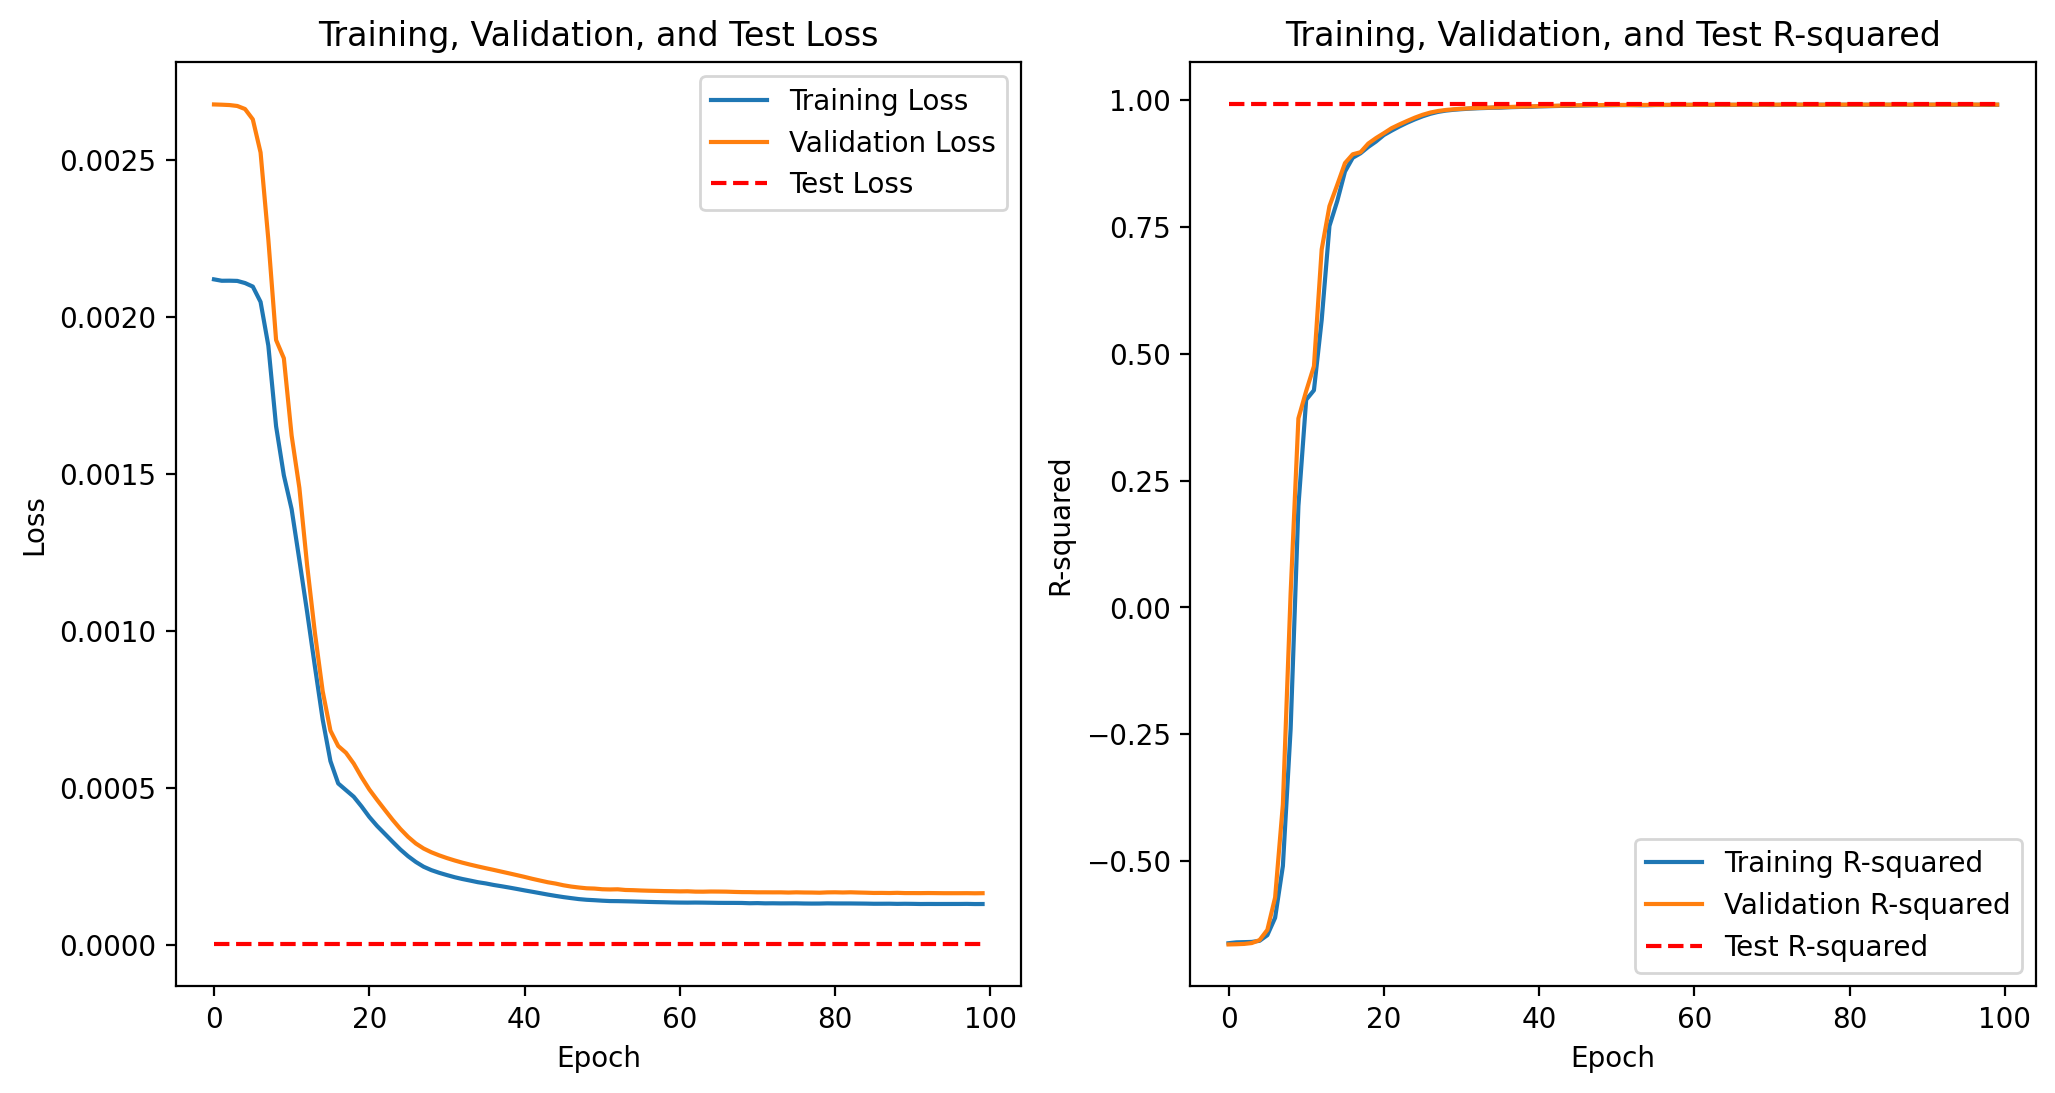

In [53]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss_list, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_list, label='Validation Loss')
plt.plot(range(EPOCHS), [test_loss] * EPOCHS, label='Test Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training, Validation, and Test Loss')

# Plot the training and validation R-squared
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), r2_list, label='Training R-squared')
plt.plot(range(EPOCHS), val_r2_list, label='Validation R-squared')
plt.plot(range(EPOCHS), [r2_test] * EPOCHS, label='Test R-squared', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training, Validation, and Test R-squared')

plt.show()


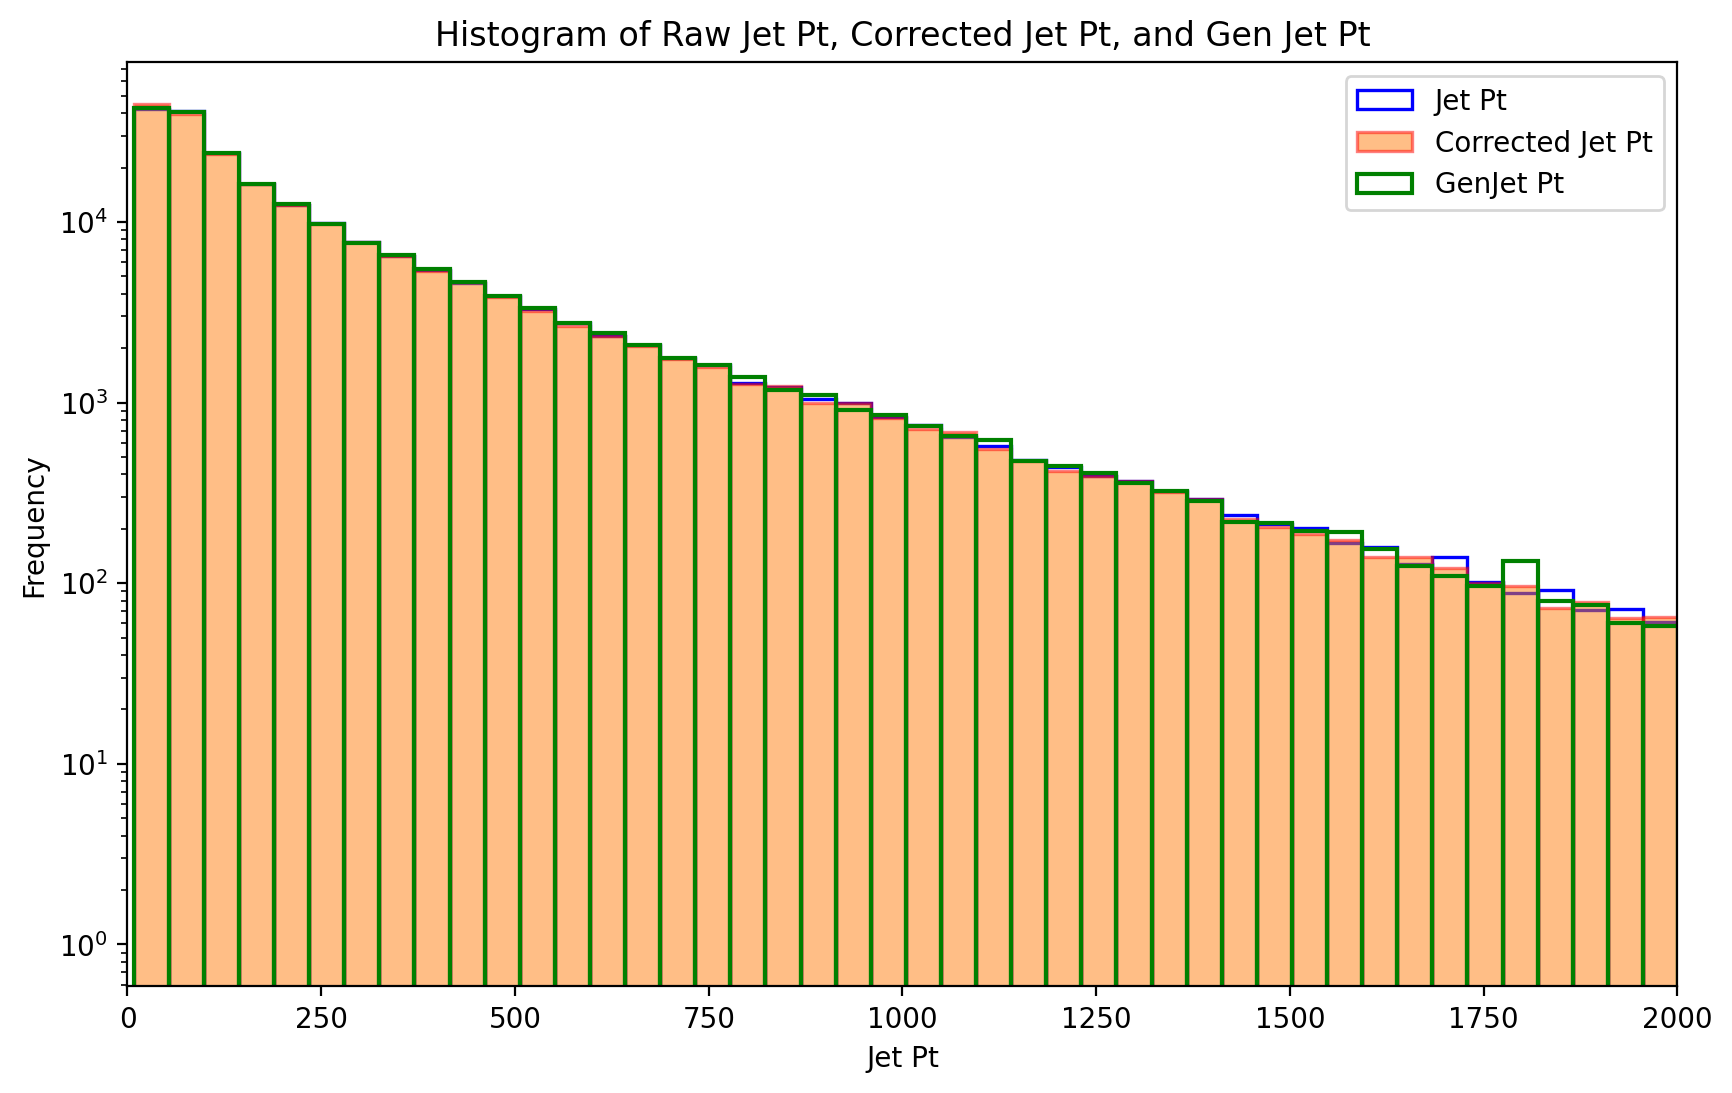

In [54]:

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Make predictions on your test data
    y_pred = model(torch.tensor(X_test, dtype=torch.float32))
    y_pred = y_pred.cpu().numpy()  # Convert predictions to NumPy array


X_test_original_scale = scaler.inverse_transform(X_test)


plt.figure(figsize=(10, 6))


common_bin_edges = np.linspace(min(X_test_original_scale[:, 0].min(), y_pred.min(), y_test.min()),
                               max(X_test_original_scale[:, 0].max(), y_pred.max(), y_test.max()), 100)

plt.hist(X_test_original_scale[:, 0], bins=common_bin_edges, label='Jet Pt', fill=0, edgecolor='blue', linewidth=1.2)


plt.hist(y_pred, bins=common_bin_edges, label='Corrected Jet Pt', edgecolor="red", alpha=0.5, linewidth=1.2)


plt.hist(y_test, bins=common_bin_edges, label='GenJet Pt', fill=0, edgecolor='green', linewidth=1.5)


plt.xlabel('Jet Pt')
plt.ylabel('Frequency')
plt.title('Histogram of Raw Jet Pt, Corrected Jet Pt, and Gen Jet Pt')
plt.xlim(0, 2000)
plt.yscale('log')
plt.legend()
plt.show()




In [55]:
def bin_ratio(rawjet_hist, genjet_hist):
    
    _, bin_edges = np.histogram(genjet_hist, bins='auto')

    ratios = []
    mean_list = []
    std_list = []

    for ibin in range(len(bin_edges) - 1):
        idx = (rawjet_hist >= bin_edges[ibin]) & (rawjet_hist <= bin_edges[ibin + 1])  # boolean mask
        ratios.append((rawjet_hist[idx] - 0 * genjet_hist[idx]) / genjet_hist[idx])

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    for hist in ratios:
        mean_list.append(np.mean(hist))
        std_list.append(np.std(hist))

    return np.array(mean_list), np.array(std_list), bin_centers, bin_edges



rawtogen_mean, rawtogen_std, bin_centers, bin_edges = bin_ratio(X_test_original_scale[:, 0], y_test)
corrtogen_mean, corrtogen_std, _, _ = bin_ratio(y_pred.flatten(), y_test)




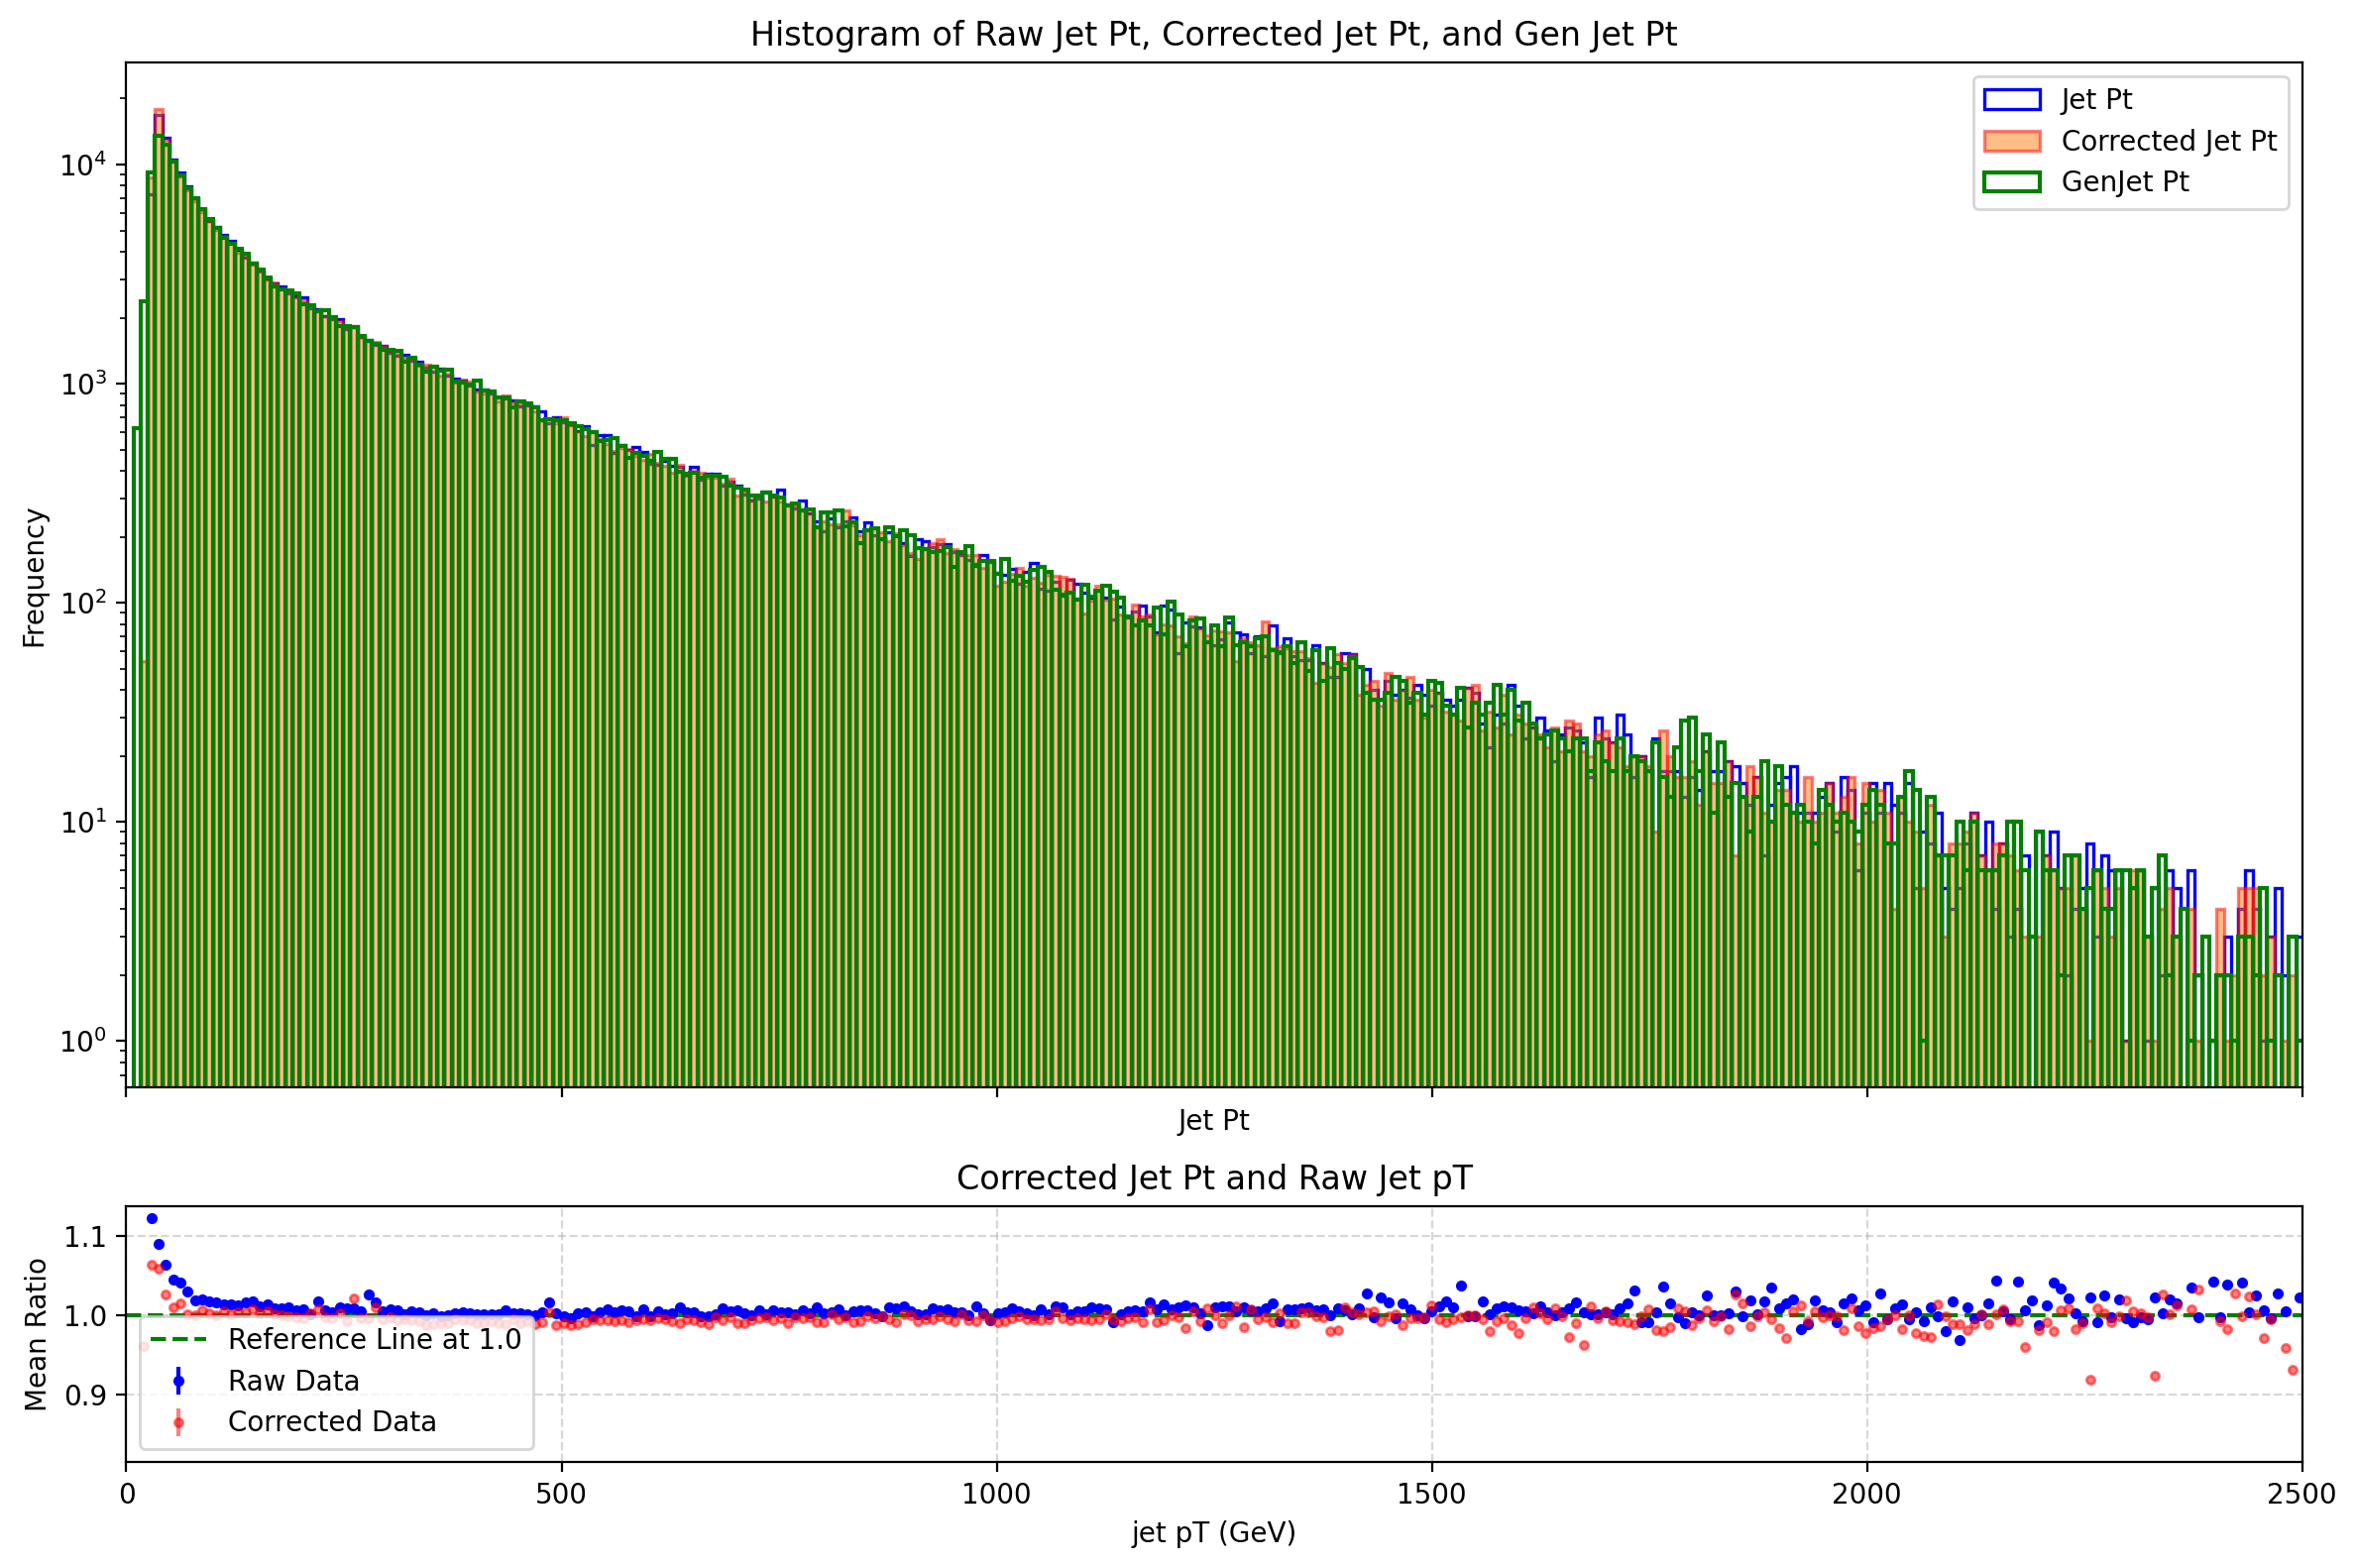

In [56]:
# Plotting the histogram and ratio plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [4, 1]}, figsize=(12, 8))


#common_bin_edges = np.linspace(min(X_test_original_scale[:, 0].min(), y_pred.min(), y_test.min()), max(X_test_original_scale[:, 0].max(), y_pred.max(), y_test.max()), 100)

ax1.hist(X_test_original_scale[:, 0], bins=bin_edges, label='Jet Pt', fill=0, edgecolor='blue', linewidth=1.2)
ax1.hist(y_pred, bins=bin_edges, label='Corrected Jet Pt', edgecolor="red", alpha=0.5, linewidth=1.2)
ax1.hist(y_test, bins=bin_edges, label='GenJet Pt', fill=0, edgecolor='green', linewidth=1.5)

ax1.set_xlabel('Jet Pt')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Raw Jet Pt, Corrected Jet Pt, and Gen Jet Pt')
ax1.set_yscale('log')
ax1.legend()


ax2.errorbar(bin_centers, rawtogen_mean, yerr=0 * rawtogen_std, fmt='o', markersize=3.0, color='blue', label='Raw Data')
ax2.errorbar(bin_centers, corrtogen_mean, yerr=0 * corrtogen_std, fmt='o', markersize=3.0, alpha=0.5, color='red', label='Corrected Data')
ax2.axhline(y=1.0, color='g', linestyle='--', label='Reference Line at 1.0')

ax2.set_xlabel('jet pT (GeV)')
ax2.set_ylabel('Mean Ratio')
ax2.set_title('Corrected Jet Pt and Raw Jet pT')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

ax1.set_xlim(0, 2500)
ax2.set_xlim(0, 2500)

plt.tight_layout()
plt.show()

/home/odokumaci/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/odokumaci/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/odokumaci/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/odokumaci/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

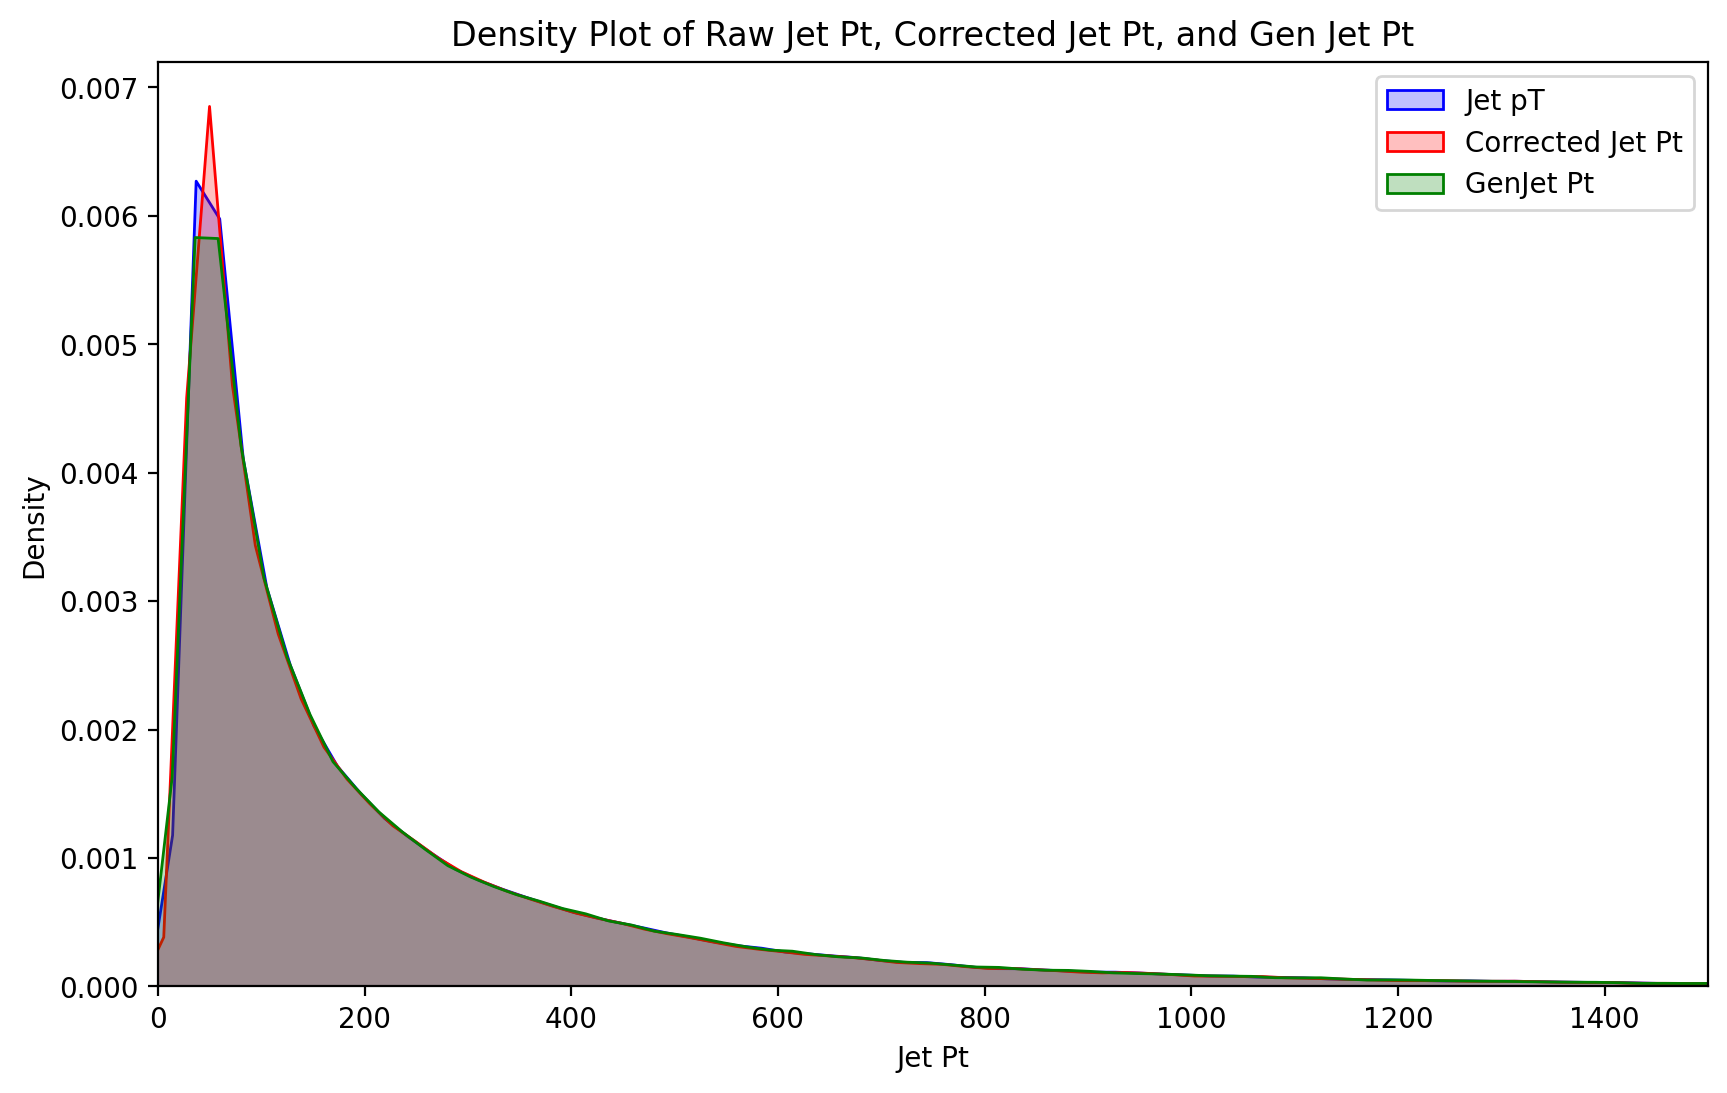

In [57]:
import seaborn as sns

plt.figure(figsize=(10, 6))


sns.kdeplot(X_test_original_scale[:, 0], label='Jet pT', color='blue', fill=True, common_norm=False, common_grid=True, bw_adjust=0.5)
sns.kdeplot(y_pred[:,0], label='Corrected Jet Pt', color='red', fill=True, common_norm=False, common_grid=True, bw_adjust=0.5)
sns.kdeplot(y_test, label='GenJet Pt', color='green', fill=True, common_norm=False, common_grid=True, bw_adjust=0.5)

plt.xlabel('Jet Pt')
plt.ylabel('Density')
plt.title('Density Plot of Raw Jet Pt, Corrected Jet Pt, and Gen Jet Pt')
#plt.yscale('log')
plt.xlim(0, 1500)

plt.legend()
plt.show()



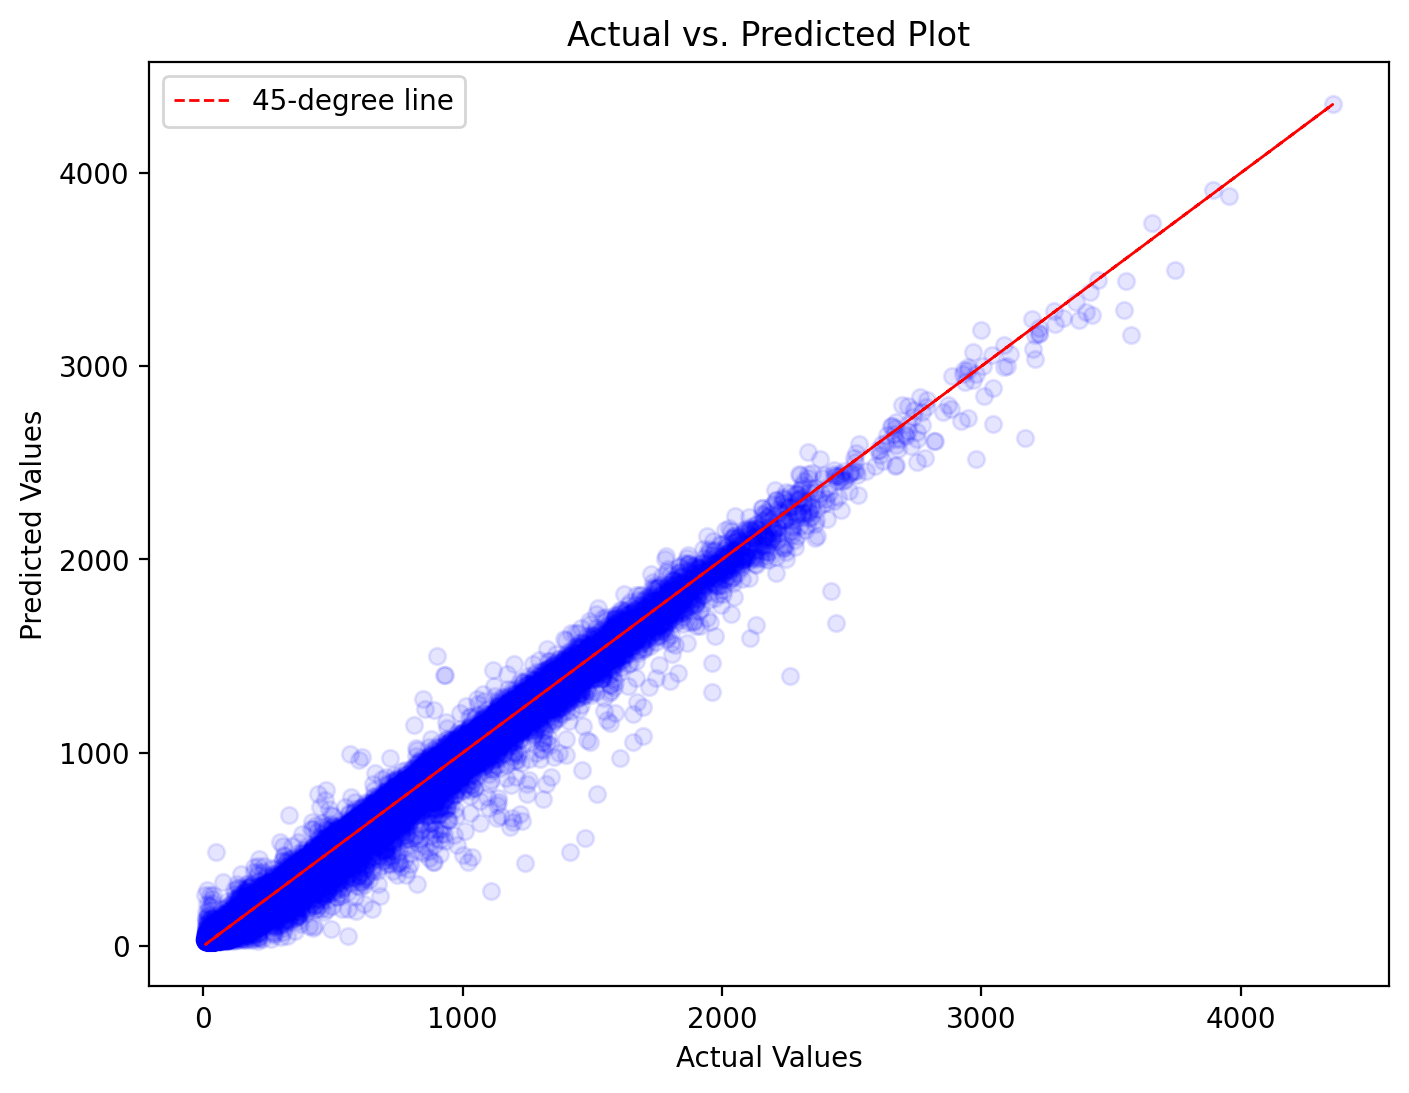

In [58]:
# Assuming you have already trained your model and have predictions
y_true = y_test  # Actual values from your test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X_test DataFrame to a PyTorch Tensor
y_pred = model(X_test_tensor).detach().cpu().numpy()  # Predicted values converted to NumPy

# Inverse transform the scaled features
X_test_original_scale = scaler.inverse_transform(X_test)


# Create an Actual vs. Predicted scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.1, color="blue", edgecolors="blue")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

# If you want to plot a 45-degree line for reference
plt.plot(y_true, y_true, color='red', linestyle='--', linewidth=1, label="45-degree line")

plt.title("Actual vs. Predicted Plot")
plt.legend()
plt.show()